In [2]:
# Imports 
import os
import sys
sys.path.append("..")
os.environ["pyna_language"] = 'julia'
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
%matplotlib inline
from pyNA.pyna import pyna

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Load verification trajectory 
pyna_settings = pyna.load_settings(case_name='stca')
pyna_settings.engine_file_name = "engine_deck_stca.csv"
pyna_settings.TS_vnrs = 1.
pyna_settings.TS_cutback = 1.
pyna_settings.z_cutback = 500.
pyna_settings.save_results = True
pyna_settings.max_iter = 100
pyna_settings.PHLD = False
pyna_settings.PKROT = False
pyna_settings.PTCB = False

py = pyna(pyna_settings)

In [4]:
# Compute trajectories for fixed flap settings 
n_krot = 9
krot_lst = np.linspace(1.1, 1.5, n_krot)

if False:
    for i, k_rot in enumerate(krot_lst):

        pyna_settings.save_results = True
        pyna_settings.output_directory_name = 'knobs/k_rot'
        pyna_settings.output_file_name = 'stca_krot_' + str(np.round(k_rot, 2)) + '.sql'

        py = pyna(pyna_settings)
        py.ac.k_rot = k_rot
        
        py.compute_trajectory(engine_mode='noise', objective = 'x_end')
        
        py.save_time_series(py.problem, py.settings, py.ac, 'trajectory_stca_krot_' + str(np.round(k_rot, 2)) + '.csv', 'engine_stca_krot_' + str(np.round(k_rot, 2)) + '.csv')
        
n_vmax = 16
vmax_lst = np.linspace(200, 250, n_vmax)*0.51444
        
if False: 
    for i, vmax in enumerate(vmax_lst):
    
        pyna_settings.save_results = True
        pyna_settings.output_directory_name = 'knobs/v_max'
        pyna_settings.output_file_name = 'stca_vmax_' + str(np.round(vmax, 2)) + '.sql'

        py = pyna(pyna_settings)
        
        py.ac.v_max = vmax
        
        py.compute_trajectory(engine_mode='trajectory', objective = 'x_end')
    
n_theta = 14
theta_flaps_lst = np.linspace(0, 26, n_theta)
        
if False: 
    for i, th in enumerate(theta_flaps_lst):
    
        pyna_settings.save_results = True
        pyna_settings.output_directory_name = 'knobs/theta_flaps'
        pyna_settings.output_file_name = 'stca_theta_' + str(np.round(th, 2)) + '.sql'

        pyna_settings.theta_flaps = th
        
        py = pyna(pyna_settings)
        py.compute_trajectory(engine_mode='trajectory', objective = 'x_end')


In [5]:
# Save time series
if False:
    for i, pyna_settings.theta_flaps in enumerate(theta_flaps_lst):
        py.save_time_series(results[str(pyna_settings.theta_flaps)], py.settings, py.ac, 'PHLD/trajectory_stca_flaps_'+str(pyna_settings.theta_flaps)+'deg.csv', 'PHLD/engine_stca_flaps_'+str(pyna_settings.theta_flaps)+'deg_.csv')

# Analysis

In [6]:
# Load trajectories
if True:
    py.settings.output_directory_name = 'knobs/k_rot'
    results = dict()
    for i, krot in enumerate(krot_lst):
        results[str(i)] = py.load_results(file_name = 'stca_krot_' + str(np.round(krot, 2)) + '.sql')
        
if False:
    py.settings.output_directory_name = 'knobs/v_max'
    results = dict()
    for i, vmax in enumerate(vmax_lst):
        results[str(i)] = py.load_results(file_name = 'stca_vmax_' + str(np.round(vmax, 2)) + '.sql')
        
if False:
    py.settings.output_directory_name = 'knobs/theta_flaps'
    results = dict()
    for i, th in enumerate(theta_flaps_lst):
        results[str(i)] = py.load_results(file_name = 'stca_theta_' + str(np.round(th, 2)) + '.sql')
        

In [7]:
# analysislyze trajectories
def analyze_trajectories(results, lst):
    
    n = np.size(lst)
    analysis = dict()
    analysis['r_min'] = np.zeros(n)
    analysis['x_end'] = np.zeros(n)
    analysis['x_groundroll'] = np.zeros(n)
    analysis['x_rotation'] = np.zeros(n)
    analysis['x_climb'] = np.zeros(n)
    
    analysis['t_liftoff'] = np.zeros(n)
    
    analysis['x_takeoff'] = np.zeros(n)
    analysis['v_climb'] = np.zeros(n)
    analysis['L_climb'] = np.zeros(n)
    analysis['D_climb'] = np.zeros(n)
    analysis['gamma_climb'] = np.zeros(n)
    analysis['alpha_climb'] = np.zeros(n)
    analysis['Fn_climb'] = np.zeros(n)
    analysis['v_end'] = np.zeros(n)
    analysis['L_end'] = np.zeros(n)
    analysis['D_end'] = np.zeros(n)
    analysis['gamma_end'] = np.zeros(n)
    analysis['alpha_end'] = np.zeros(n)
    analysis['Fn_end'] = np.zeros(n)

    analysis['Vlo'] = np.zeros(n)
    analysis['Vrot'] = np.zeros(n)
    
    analysis['L_D'] = np.zeros(n)
    
    for i, _ in enumerate(lst):
        x = results[str(i)].get_val('trajectory.x')
        y = results[str(i)].get_val('trajectory.y')
        z = results[str(i)].get_val('trajectory.z')
        x_obs = np.array([6500., 0., 4*0.3048])
        
        analysis['r_min'][i] = np.min( np.sqrt((x-x_obs[0])**2+(y-x_obs[1])**2+(z-x_obs[2])**2) )
        analysis['x_end'][i] = x[-1]
        analysis['x_groundroll'][i] = results[str(i)].get_val('phases.groundroll.interpolated.states:x')[-1]
        analysis['x_rotation'][i] = results[str(i)].get_val('phases.rotation.interpolated.states:x')[-1] - results[str(i)].get_val('phases.groundroll.interpolated.states:x')[-1]
        analysis['x_climb'][i] = results[str(i)].get_val('phases.liftoff.interpolated.states:x')[-1] - results[str(i)].get_val('phases.rotation.interpolated.states:x')[-1]
        
        analysis['t_liftoff'][i] = results[str(i)].get_val('phases.liftoff.t_duration')
        
        analysis['x_takeoff'][i] = results[str(i)].get_val('phases.liftoff.interpolated.states:x')[-1]
        analysis['v_climb'][i] = results[str(i)].get_val('phases.liftoff.interpolated.states:v')[-1]
        analysis['L_climb'][i] = results[str(i)].get_val('phases.liftoff.interpolated.L')[-1]
        analysis['D_climb'][i] = results[str(i)].get_val('phases.liftoff.interpolated.D')[-1]
        analysis['gamma_climb'][i] = results[str(i)].get_val('phases.liftoff.interpolated.states:gamma')[-1]
        analysis['alpha_climb'][i] = results[str(i)].get_val('phases.liftoff.interpolated.controls:alpha')[-1]
        analysis['Fn_climb'][i] = results[str(i)].get_val('phases.liftoff.interpolated.F_n')[-1]
        analysis['v_end'][i] = results[str(i)].get_val('trajectory.v')[-1]
        analysis['L_end'][i] = results[str(i)].get_val('trajectory.L')[-1]
        analysis['D_end'][i] = results[str(i)].get_val('trajectory.D')[-1]
        analysis['gamma_end'][i] = results[str(i)].get_val('trajectory.gamma')[-1]
        analysis['alpha_end'][i] = results[str(i)].get_val('trajectory.alpha')[-1]
        analysis['Fn_end'][i] = results[str(i)].get_val('trajectory.F_n')[-1]

        analysis['Vlo'][i] = results[str(i)].get_val('phases.rotation.interpolated.states:v')[-1]
        analysis['Vrot'][i] = results[str(i)].get_val('phases.groundroll.interpolated.states:v')[-1]
        
        analysis['L_D'][i] =  np.mean(results[str(i)].get_val('phases.cutback.interpolated.c_l')/results[str(i)].get_val('phases.cutback.interpolated.c_d')) 
        
#         pdb.set_trace()
    return analysis

ana = analyze_trajectories(results, krot_lst)
# ana = analyze_trajectories(results, theta_flaps_lst)

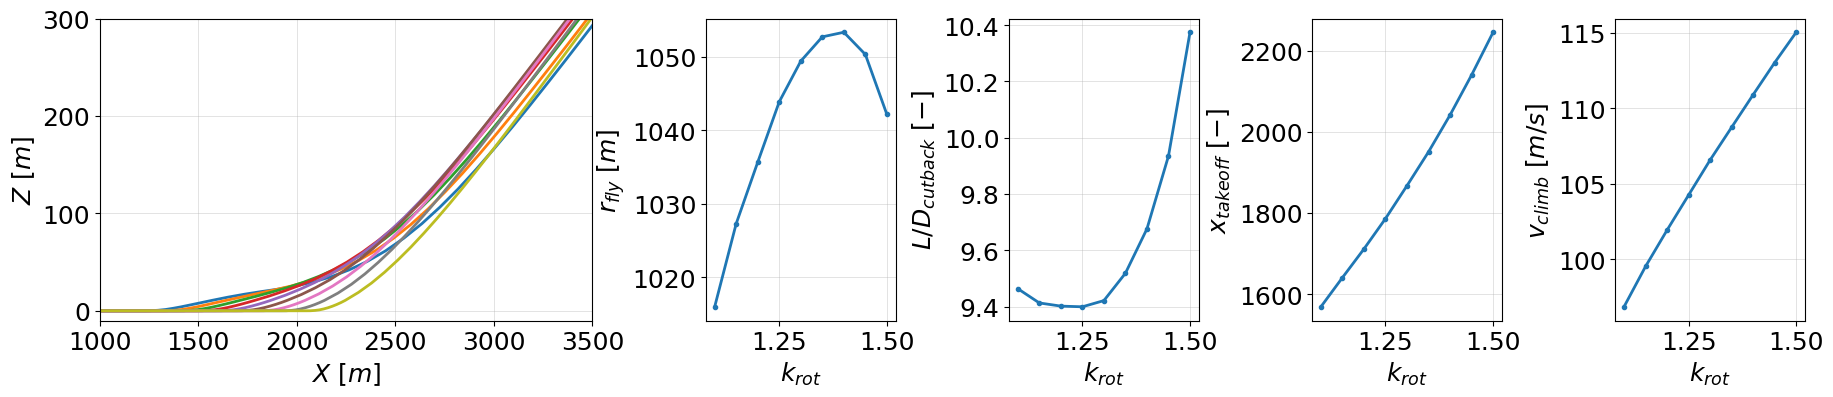

In [15]:
# Figure 
fig = plt.figure(figsize=(22,4))
plt.style.use('../utils/plot.mplstyle')
gs = fig.add_gridspec(1,6)
ax1 = fig.add_subplot(gs[0, :2])
for i, th in enumerate(krot_lst):
    ax1.plot(results[str(i)].get_val('trajectory.x'), results[str(i)].get_val('trajectory.z'), linewidth=2)
ax1.plot([6500], [50], )
ax1.set_xlabel(r'$X\ [m]$')
ax1.set_ylabel(r'$Z\ [m]$')
ax1.set_xlim([1000, 3500])
ax1.set_ylim([-10, 300])

# ax2 = fig.add_subplot(gs[0, 2])
# ax2.plot(krot_lst, ana['x_end'], 'o-')
# ax2.set_xlabel(r'$k_{rot}$')
# ax2.set_ylabel(r'$x_{end}\ [-]$')

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(krot_lst, ana['r_min'], 'o-')
ax3.set_xlabel(r'$k_{rot}$')
ax3.set_ylabel(r'$r_{fly}\ [m]$')

ax4 = fig.add_subplot(gs[0, 3])
ax4.plot(krot_lst, ana['L_end']/ana['D_end'], 'o-')
ax4.set_xlabel(r'$k_{rot}$')
ax4.set_ylabel(r'$L/D_{cutback}\ [-]$')

ax5 = fig.add_subplot(gs[0, 4])
ax5.plot(krot_lst, ana['x_takeoff'], 'o-')
ax5.set_xlabel(r'$k_{rot}$')
ax5.set_ylabel(r'$x_{takeoff}\ [-]$')

ax6 = fig.add_subplot(gs[0, 5])
ax6.plot(krot_lst, ana['v_climb'], 'o-')
ax6.set_xlabel(r'$k_{rot}$')
ax6.set_ylabel(r'$v_{climb}\ [m/s]$')

plt.subplots_adjust(wspace=0.6)

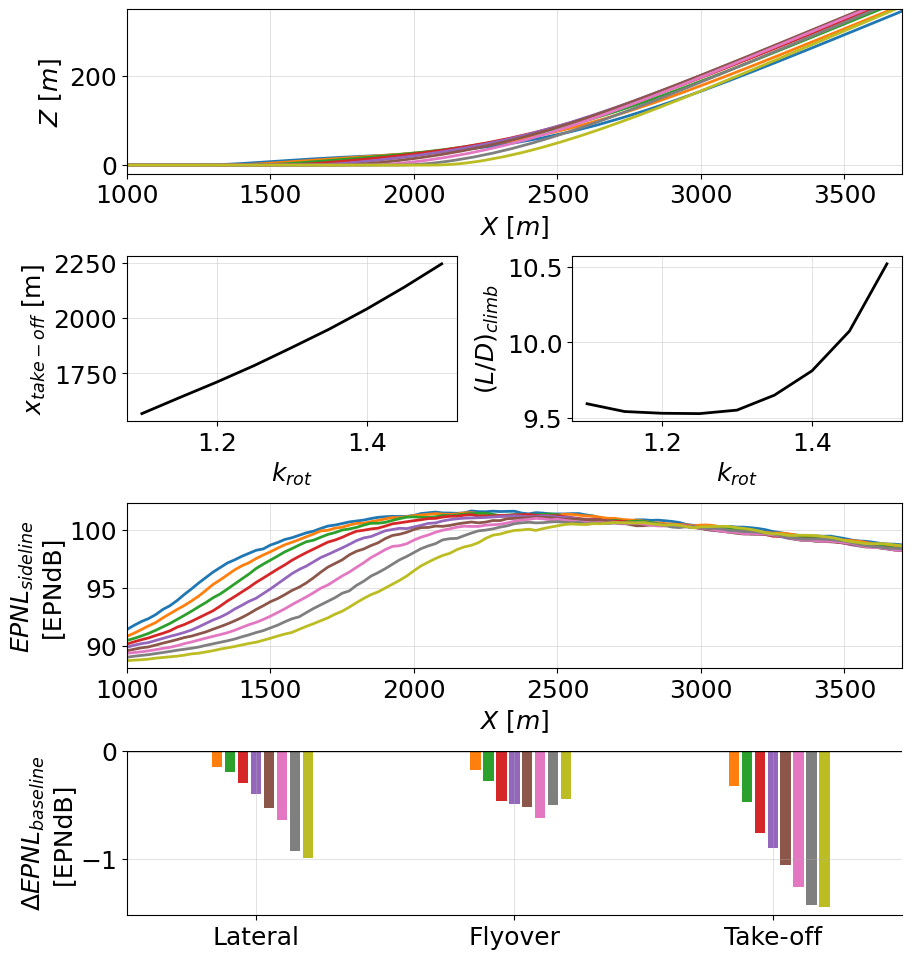

In [80]:
fig = plt.figure(figsize=(10,12))
plt.style.use('../utils/plot.mplstyle')

gs = fig.add_gridspec(4,2)
ax0 = fig.add_subplot(gs[0, :])

for i, th in enumerate(krot_lst):
    ax0.plot(results[str(i)].get_val('trajectory.x'), results[str(i)].get_val('trajectory.z'), linewidth=2)
ax0.plot([6500], [50], )
ax0.set_xlabel(r'$X\ [m]$')
ax0.set_ylabel(r'$Z\ [m]$')
ax0.set_xlim([1000, 3700])
ax0.set_ylim([-20, 350])

ax1a = fig.add_subplot(gs[1, 0])
ax1a.plot(krot_lst, ana['x_takeoff'], 'k')
ax1a.set_xlabel('$k_{rot}$')
ax1a.set_ylabel('$x_{take-off}$ [m]')

ax1b = fig.add_subplot(gs[1, 1])
ax1b.plot(krot_lst, ana['L_D'], 'k')
ax1b.set_xlabel('$k_{rot}$')
ax1b.set_ylabel('$(L/D)_{climb}$')

ax2 = fig.add_subplot(gs[2, :])
for i, k_rot in enumerate(krot_lst):
    ax2.plot(x, epnl_sideline[i,:])
    ax2.set_ylabel('$EPNL_{sideline}$\n[EPNdB]')
ax2.set_xlim([1000, 3700])
ax2.set_xlabel(r'$X\ [m]$')

ax3 = fig.add_subplot(gs[3, :])

delta_l = epnl_lateral-epnl_lateral[0]
delta_f = epnl_flyover-epnl_flyover[0]
delta_t = epnl_takeoff-epnl_takeoff[0]

colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 'tab:olive']
bar_l = plt.bar(np.linspace(-0.2, +0.2, 9), delta_l, width=0.04, color=colors)
bar_f = plt.bar(np.linspace(-0.2, +0.2, 9)+1, delta_f, width=0.04, color=colors)
bar_t = plt.bar(np.linspace(-0.2, +0.2, 9)+2, delta_t, width=0.04, color=colors)
ax3.set_xticks(np.arange(3))
ax3.set_xticklabels(['Lateral', 'Flyover', 'Take-off'])

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax3.plot([-0.5,2.5], [0,0], 'k', linewidth=1)
ax3.set_xlim([-0.5, 2.5])

ax3.set_ylabel('$\Delta EPNL_{baseline}$\n[EPNdB]')

plt.subplots_adjust(hspace=0.5, wspace=0.35)

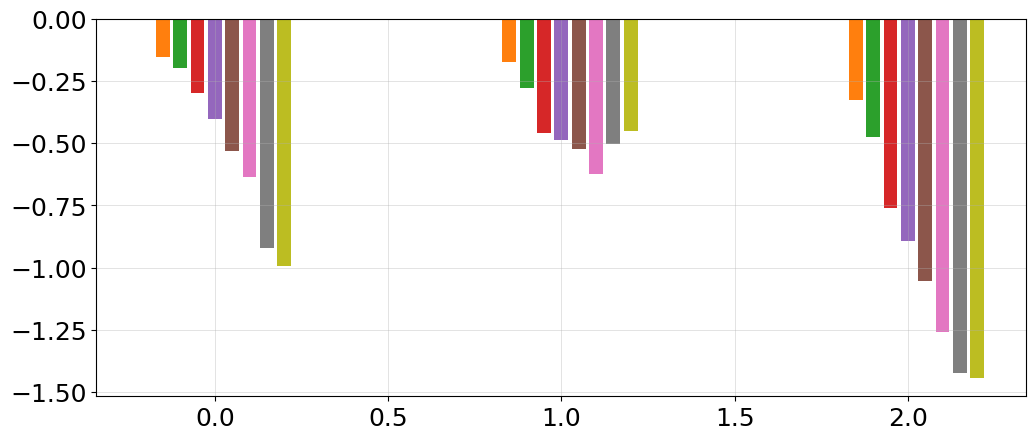

In [75]:
delta_l = epnl_lateral-epnl_lateral[0]
delta_f = epnl_flyover-epnl_flyover[0]
delta_t = epnl_takeoff-epnl_takeoff[0]

colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 'tab:olive']
bar_l = plt.bar(np.linspace(-0.2, +0.2, 9), delta_l, width=0.04, color=colors)
bar_f = plt.bar(np.linspace(-0.2, +0.2, 9)+1, delta_f, width=0.04, color=colors)
bar_t = plt.bar(np.linspace(-0.2, +0.2, 9)+2, delta_t, width=0.04, color=colors)
# ax3.set_xticks(np.arange(3))
# ax3.set_xticklabels(['Lateral', 'Flyover', 'Take-off'])

# ax3.spines['right'].set_visible(False)
# ax3.spines['top'].set_visible(False)

# ax3.plot([-0.5,2.5], [0,0], 'k', linewidth=1)

# ax3.set_ylabel('$\Delta EPNL_{baseline}$\n[EPNdB]')

plt.show()

## Compute noise

In [41]:
# Compute noise for the different trajectories
n = 181
epnl_sideline = np.zeros((np.size(krot_lst), n))
epnl_lateral = np.zeros(np.size(krot_lst))
epnl_flyover = np.zeros(np.size(krot_lst))
epnl_takeoff = np.zeros(np.size(krot_lst))
for i, k_rot in enumerate(krot_lst):
    pyna_settings.engine_file_name = 'knobs/k_rot/engine_stca_krot_' + str(np.round(k_rot, 2)) + '.csv'
    pyna_settings.trajectory_file_name = 'knobs/k_rot/trajectory_stca_krot_' + str(np.round(k_rot, 2)) + '.csv'
    pyna_settings.levels_int_metric = 'epnl' 
    pyna_settings.observer_lst = {'contours',}
    
    x = np.linspace(1000, 5500, n)
    pyna_settings.x_observer_array = np.zeros((n+1, 3))
    pyna_settings.x_observer_array[:-1,0] = x
    pyna_settings.x_observer_array[:-1,1] = 450.*np.ones(n)
    pyna_settings.x_observer_array[:-1,2] = 4*0.3048*np.ones(n)
    pyna_settings.x_observer_array[-1,:] = np.array((6500., 0., 4*0.3048))

    py = pyna(pyna_settings)
    py.compute_noise_time_series()
    
    epnl_sideline[i,:] = py.problem.get_val('noise.epnl')[:-1]
    epnl_lateral[i] = np.max(py.problem.get_val('noise.epnl')[:-1])
    epnl_flyover[i] = py.problem.get_val('noise.epnl')[-1]
    epnl_takeoff[i] = epnl_lateral[i] + epnl_flyover[i] 

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/stca/output/Trajectory_stca.sql, is being overwritten.
/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/stca/dymos_solution.db, is being overwritten.


Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been r

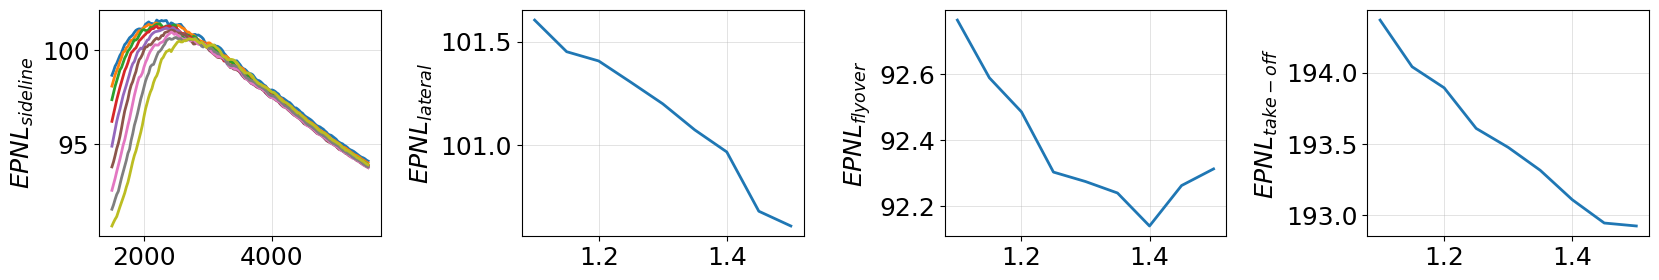

In [25]:
fig, ax = plt.subplots(1,4, figsize=(20,3))
for i, k_rot in enumerate(krot_lst):
    ax[0].plot(x, epnl_sideline[i,:])
    ax[0].set_ylabel('$EPNL_{sideline}$')
ax[1].plot(krot_lst, epnl_lateral)
ax[1].set_ylabel('$EPNL_{lateral}$')
ax[2].plot(krot_lst, epnl_flyover)
ax[2].set_ylabel('$EPNL_{flyover}$')
ax[3].plot(krot_lst, epnl_takeoff)
ax[3].set_ylabel('$EPNL_{take-off}$')
plt.subplots_adjust(wspace=0.5)

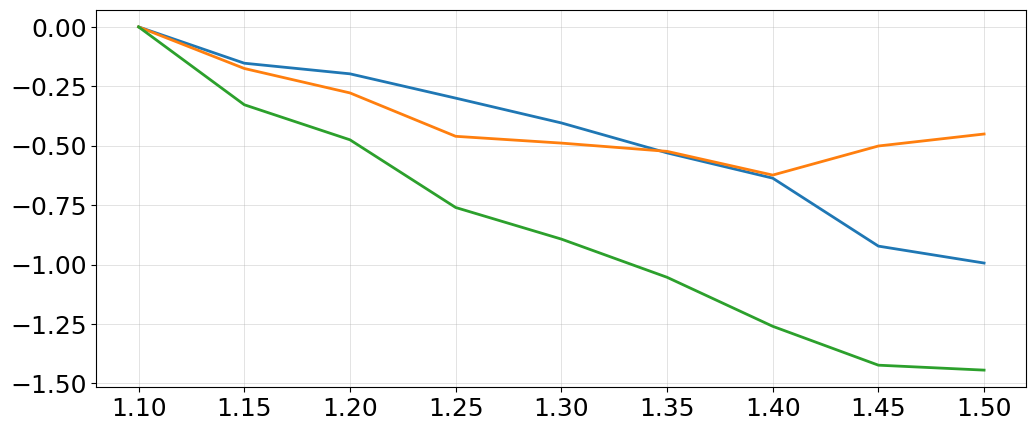

In [57]:
plt.plot(krot_lst, )
plt.plot(krot_lst, )
plt.plot(krot_lst, )


### Vary theta_flaps

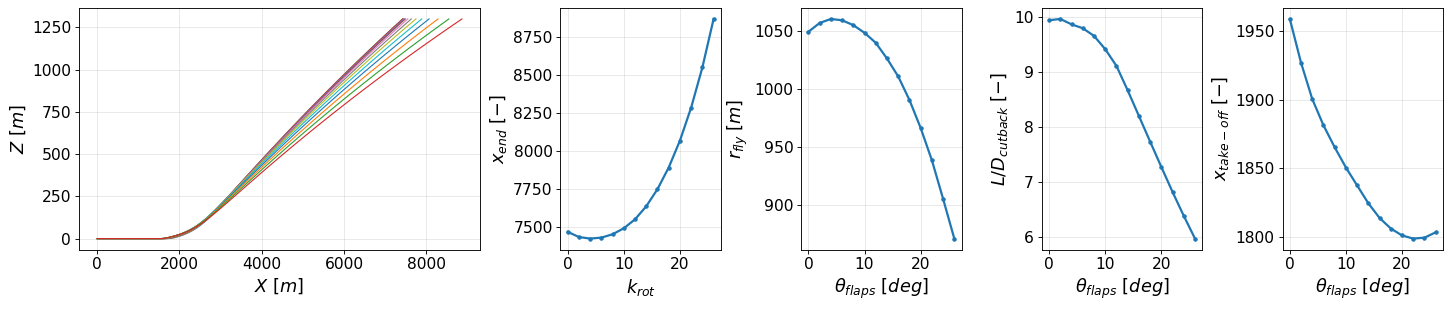

In [10]:
fig = plt.figure(figsize=(22,4))
plt.style.use('../utils/plot.mplstyle')
gs = fig.add_gridspec(1,6)
ax1 = fig.add_subplot(gs[0, :2])
for i, th in enumerate(theta_flaps_lst):
    ax1.plot(results[str(i)].get_val('trajectory.x'), results[str(i)].get_val('trajectory.z'), linewidth=1)
ax1.plot([6500], [50], )
ax1.set_xlabel(r'$X\ [m]$')
ax1.set_ylabel(r'$Z\ [m]$')
    
ax2 = fig.add_subplot(gs[0, 2])
ax2.plot(theta_flaps_lst, ana['x_end'], 'o-')
ax2.set_xlabel(r'$theta_{flaps}\ [deg]$')
ax2.set_ylabel(r'$x_{end}\ [-]$')
    
ax3 = fig.add_subplot(gs[0, 3])
ax3.plot(theta_flaps_lst, ana['r_min'], 'o-')
ax3.set_xlabel(r'$\theta_{flaps}\ [deg]$')
ax3.set_ylabel(r'$r_{fly}\ [m]$')

ax4 = fig.add_subplot(gs[0, 4])
ax4.plot(theta_flaps_lst, ana['L_end']/ana['D_end'], 'o-')
ax4.set_xlabel(r'$\theta_{flaps}\ [deg]$')
ax4.set_ylabel(r'$L/D_{cutback}\ [-]$')

ax5 = fig.add_subplot(gs[0, 5])
ax5.plot(theta_flaps_lst, ana['x_takeoff'], 'o-')
ax5.set_xlabel(r'$\theta_{flaps}\ [deg]$')
ax5.set_ylabel(r'$x_{take-off}\ [-]$')

plt.subplots_adjust(wspace=0.5)

In [17]:
ana['x_takeoff'][np.argmin(ana['x_end'])]

1900.4017783796576

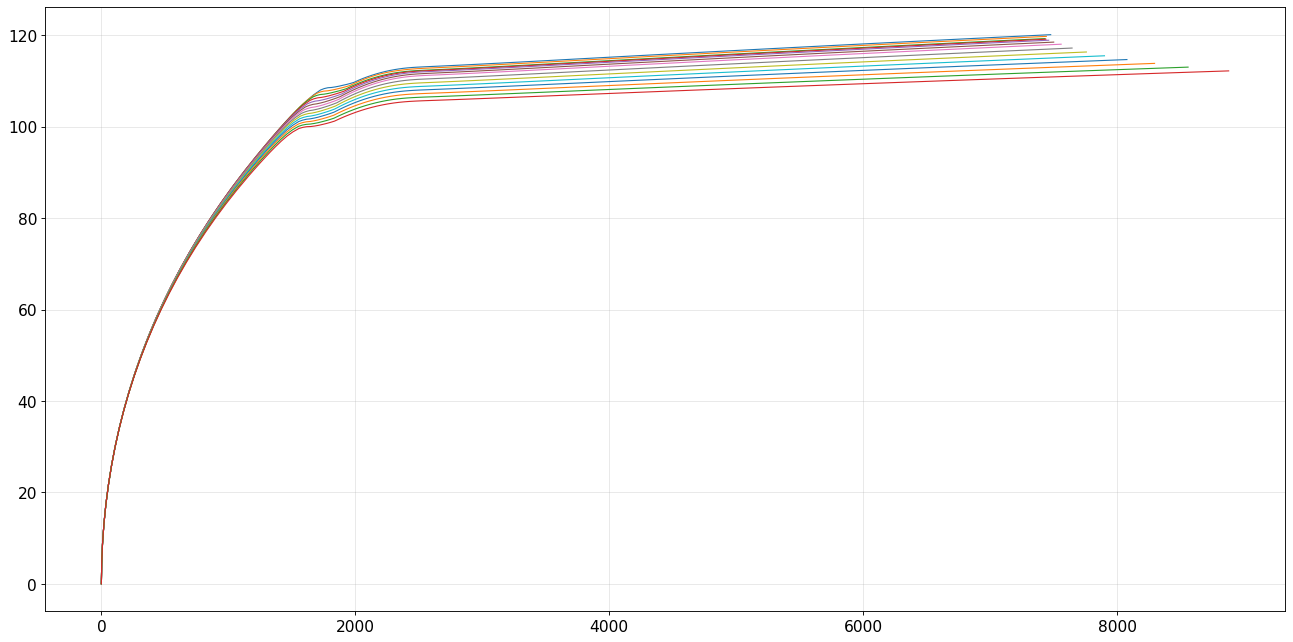

In [29]:
plt.figure(figsize=(20,10))
for i, th in enumerate(theta_flaps_lst):
    plt.plot(results[str(i)].get_val('trajectory.x'), results[str(i)].get_val('trajectory.v'), linewidth=1)
# plt.ylim([-10, 400])
# plt.xlim([-100, 4000])

NameError: name 'theta_flaps_lst' is not defined

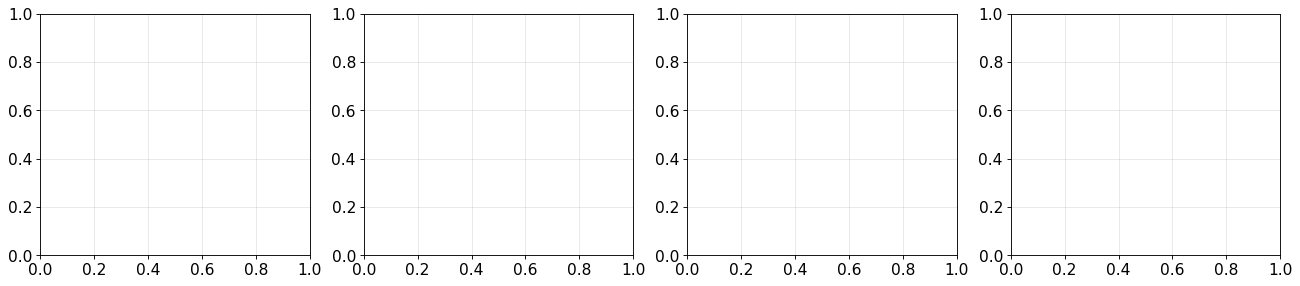

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))
plt.style.use('../utils/plot.mplstyle')

ax[1].plot(theta_flaps_lst, analysis_A['x_groundroll'])
ax[1].plot(theta_flaps_lst, analysis_B['x_groundroll'])
ax[1].plot(theta_flaps_lst, analysis_C['x_groundroll'])
ax[1].plot(theta_flaps_lst, analysis_D['x_groundroll'])

ax[2].plot(theta_flaps_lst, analysis_A['x_rotation'])
ax[2].plot(theta_flaps_lst, analysis_B['x_rotation'])
ax[2].plot(theta_flaps_lst, analysis_C['x_rotation'])
ax[2].plot(theta_flaps_lst, analysis_D['x_rotation'])

ax[3].plot(theta_flaps_lst, analysis_A['x_climb'])
ax[3].plot(theta_flaps_lst, analysis_B['x_climb'])
ax[3].plot(theta_flaps_lst, analysis_C['x_climb'])
ax[3].plot(theta_flaps_lst, analysis_D['x_climb'])

ax[0].plot(theta_flaps_lst, analysis_A['x_takeoff'])
ax[0].plot(theta_flaps_lst, analysis_B['x_takeoff'])
ax[0].plot(theta_flaps_lst, analysis_C['x_takeoff'])
ax[0].plot(theta_flaps_lst, analysis_D['x_takeoff'])
ax[0].set_xlabel(r'$\theta_{flaps}$ [deg]')
ax[0].set_ylabel(r'$x_{TO}$')
ax[0].set_xlim([-1, 27])

# ax[0].plot(theta_flaps_lst, analysis_A['r_min'])
# ax[0].plot(theta_flaps_lst, analysis_B['r_min'])
# ax[0].plot(theta_flaps_lst, analysis_C['r_min'])
# ax[0].plot(theta_flaps_lst, analysis_D['r_min'])
# ax[0].set_xlabel(r'$\theta_{flaps}$ [deg]')
# ax[0].set_ylabel(r'$r_{fly}$')#'/r_{fly, max}$')
# # ax[0].set_ylim([0.8, 1.02])
# ax[0].set_xlim([-1, 27])

plt.subplots_adjust(wspace=0.3, hspace=0.4)

In [ ]:
case = '8.0'
plt.plot(results_A[case].get_val('trajectory.L')/results_A[case].get_val('trajectory.D'))
plt.plot(results_B[case].get_val('trajectory.L')/results_B[case].get_val('trajectory.D'))
plt.plot(results_C[case].get_val('trajectory.L')/results_C[case].get_val('trajectory.D'))
plt.plot(results_D[case].get_val('trajectory.L')/results_D[case].get_val('trajectory.D'))

In [ ]:
for i, pyna_settings.theta_flaps in enumerate(theta_flaps_lst):
    plt.plot(results_A[str(pyna_settings.theta_flaps)].get_val('phases.climb.interpolated.states:x')-results_A[str(pyna_settings.theta_flaps)].get_val('phases.climb.interpolated.states:x')[0], 
             results_A[str(pyna_settings.theta_flaps)].get_val('phases.climb.interpolated.states:z'))
# plt.ylim([0, 20])
# plt.xlim([1500, 2200])

In [ ]:
# Compute noise of trajectories 
epnl_sideline = np.zeros((np.size(theta_flaps_lst), 161))
epnl_lateral = np.zeros(np.size(theta_flaps_lst))
epnl_flyover = np.zeros(np.size(theta_flaps_lst))

if False:
    for i, pyna_settings.theta_flaps in enumerate(theta_flaps_lst):
        py.settings.engine_file_name = 'PHLD/constant_flaps/engine_stca_flaps_' + str(pyna_settings.theta_flaps) + 'deg.csv'
        py.settings.trajectory_file_name = 'PHLD/constant_flaps/trajectory_stca_flaps_' + str(pyna_settings.theta_flaps) + 'deg.csv'
        py.settings.observer_lst = ['contour',]

        x_observer_lst = np.zeros((162, 3))
        x_observer_lst[:-1, 0] = np.linspace(1500, 5500, 161)
        x_observer_lst[:-1, 1] = 450*np.ones(161)
        x_observer_lst[:, 2] = 4*0.3048*np.ones(162)
        x_observer_lst[-1,0] = 6500.

        py.settings.x_observer_array = x_observer_lst
        py.compute_noise_time_series()

        epnl_sideline[i] = py.problem.get_val('noise.epnl')[:-1]
        epnl_lateral[i] = np.max(py.problem.get_val('noise.epnl')[:-1])
        epnl_flyover[i] = py.problem.get_val('noise.epnl')[-1]
        
# # Save noise series
# np.save('../cases/stca/output/PHLD/constant_flaps/epnl_sideline.npy', epnl_sideline)
# np.save('../cases/stca/output/PHLD/constant_flaps/epnl_lateral.npy', epnl_lateral)
# np.save('../cases/stca/output/PHLD/constant_flaps/epnl_flyover.npy', epnl_flyover)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))
plt.style.use('../utils/plot.mplstyle')

i_max_r = np.argmax(r_min)
i_min_x = np.argmin(x_takeoff)  
# i_min_epnl = np.argmin(epnl_flyover)

ax[2].plot(theta_flaps_lst, x_takeoff/x_takeoff[i_min_x])
ax[2].plot([theta_flaps_lst[np.argmin(x_takeoff)], theta_flaps_lst[np.argmin(x_takeoff)]], [0.8, 1.17], 'k--')
ax[2].set_xlabel(r'$\theta_{flaps}$ [deg]')
ax[2].set_ylabel(r'$x_{TO}/x_{TO, min}$')
ax[2].set_ylim([0.98, 1.17])
ax[2].set_xlim([-1, 27])
# ax[2].annotate("", xy=(6., (x_takeoff/x_takeoff[i_min_x])[i_max_r]+0.01), xycoords='data', xytext=(6., 0.998), textcoords='data', arrowprops=dict(arrowstyle="->, head_width=0.4", connectionstyle="arc3", linewidth=2))
# ax[2].annotate(xy=(3.7, 1.025), s='+'+str(np.round(100*(x_takeoff/x_takeoff[i_min_x]-1.)[i_max_r], 1)) + "%", fontsize=16, backgroundcolor='w')
# ax[2].plot([5.5, 22], [0.999,0.999], 'k', linewidth=1.2)
# ax[2].annotate(s=r"$\theta_{flap, min(x)}$", xy=(19, 1.073), fontsize=16, backgroundcolor='w')

ax[1].plot(theta_flaps_lst, r_min/r_min[i_max_r])
ax[1].plot([theta_flaps_lst[np.argmax(r_min)], theta_flaps_lst[np.argmax(r_min)]], [0.8, 1.05], 'k--')
ax[1].set_xlabel(r'$\theta_{flaps}$ [deg]')
ax[1].set_ylabel(r'$r_{fly}/r_{fly, max}$')
ax[1].set_ylim([0.8, 1.02])
ax[1].set_xlim([-1, 27])
# ax[1].annotate("", xy=(22., 1.001), xycoords='data', xytext=(22., (r_min/r_min[i_max_r])[i_min_x]), textcoords='data', arrowprops=dict(arrowstyle="<-, head_width=0.4", connectionstyle="arc3", linewidth=2))
# ax[1].annotate(xy=(20., 0.945), s='-'+str(np.round(100*(1-r_min/r_min[i_max_r])[i_min_x], 1)) + "%", fontsize=16, backgroundcolor='w')
# ax[1].plot([6, 22.5], [1.001,1.001], 'k', linewidth=1.2)
# ax[1].annotate(s=r"$\theta_{flap, max(r)}$", xy=(4.5, 0.917), fontsize=16, backgroundcolor='w')

# ax[0].plot([theta_flaps_lst[i_min_epnl], theta_flaps_lst[i_min_epnl]], [89.5, 102.5], 'k--')
# ax[0].plot([6, 22.5], [np.min(epnl_flyover), np.min(epnl_flyover)], 'k', linewidth=1.2)
# ax[0].annotate("", xy=(22., epnl_flyover[i_min_x]), xycoords='data', xytext=(22., np.min(epnl_flyover)-0.15), textcoords='data', arrowprops=dict(arrowstyle="->, head_width=0.4", connectionstyle="arc3", linewidth=2))
# ax[0].annotate(xy=(22.5, 91.5), s="+"+str(np.round(epnl_flyover[i_min_x]-np.min(epnl_flyover),1))+"EPNdB", fontsize=16, backgroundcolor='w')
# ax[0].plot(theta_flaps_lst, epnl_lateral, label='Lateral')
# ax[0].plot(theta_flaps_lst, epnl_flyover, label='Flyover')
# ax[0].set_ylim([89.5, 102.5])
# ax[0].set_xlabel(r'$\theta_{flaps}$ [deg]')
# ax[0].set_ylabel(r'$EPNL$ [EPNdB]')
# ax[0].annotate(s=r"$\theta_{flap, min(EPNL)}$", xy=(4., 96.5), fontsize=16, backgroundcolor='w')
# ax[0].legend(fontsize=16, ncol=1, borderaxespad=0, frameon=False)

plt.subplots_adjust(wspace=0.3, hspace=0.4)